In [36]:
import os
import glob
import pandas as pd
import csv
from io import StringIO
import io
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import humanize
import statsmodels.api as sm
from scipy.stats import norm
import sys
scriptpath = r'....\\Springboard\\capstone1'
sys.path.insert(1, scriptpath)
import FunctionsKick as fkick
from scipy.stats import t
from scipy import stats
import statsmodels.api as sa
import statsmodels.formula.api as sfa
import scikit_posthocs as sp
from itertools import combinations

## 1.1 Read Data - CSV

In [2]:
kick_data_cleaned = pd.read_csv('kick_data_cleaned.csv',index_col = None)

# 2. Frequentist Testings

The distribution for the amount requested for each project (USD_goal_real) is close to normal; therefore, we can use frequentist framework of analysis.

__Q__: We found that the Technology and Food projects tend to ask for more more funding for the project. [[1]](/notebooks/Desktop/Springboard/capstone1/1.1_data_wrangling_and_storytelling.ipynb#3.2_Main_Categories). But is there a significant difference between the two of them?

$H_{0}$: There isn't any difference in requested amounts between Technology and Food. $H_{1}$: There is difference between requested amounts between Technology and Food.

In [6]:
kick_data_cleaned['log_usd_goal_real'] = kick_data_cleaned.usd_goal_real.apply(fkick.log2)

In [7]:
technology = kick_data_cleaned.query(" main_category == 'Technology'")['log_usd_goal_real']
food = kick_data_cleaned.query(" main_category == 'Food'")['log_usd_goal_real']

In [8]:
print(np.var(technology),np.var(food)) # variance is not equal

0.4776103594518814 1.18059941560319


In [9]:
stats.ttest_ind(technology,food,equal_var = False)

Ttest_indResult(statistic=38.51869039988254, pvalue=0.0)

__Observation__: This shows that funding requested by Technology vs. Food projects are significantly different.

# 3. Multiple Groups Testings

If we want to compare whether there is difference between all of the category groups? We would need to do ANOVA and compare them individually using a post-hoc test.

$H_{0}$: There is no difference between the mean of requested amount per category. $H_{1}$: There is difference between the mean of requested amount per category. 

In [4]:
def posthoc(figsize, val_col,group_col, data):
    fig = plt.figure(figsize = figsize)
    #construct ols statement
    concat = ' {} ~ C({})'.format(val_col,group_col)
    print(concat)
    lm = sfa.ols(concat, data=kick_data_cleaned).fit()
    
    print('General ANOVA Test')
    anova = sa.stats.anova_lm(lm)
    print(anova)
    
    #post hoc
    post_hocs = sp.posthoc_scheffe(kick_data_cleaned, val_col=val_col, group_col= group_col, p_adjust='holm')
    
    #heatmap
    ax = sns.heatmap(post_hocs.iloc[:,1:],cbar_kws={'ticks': [0.0, 0.01, 0.05]}, vmin=0, vmax=0.5, linewidths=.2,cmap="YlOrRd",
                    annot = True, fmt = '01.2f')
    plt.title('Post-Hoc Analysis Results', fontdict = {'fontsize': 15}, loc = 'center', pad = 0.8)
    ax.set(xlabel = group_col, ylabel = group_col)
    plt.tight_layout()
    return ax


 log_usd_goal_real ~ C(main_category)
General ANOVA Test
                        df         sum_sq      mean_sq            F  PR(>F)
C(main_category)      14.0   99776.296139  7126.878296  2720.724668     0.0
Residual          378646.0  991854.850776     2.619478          NaN     NaN


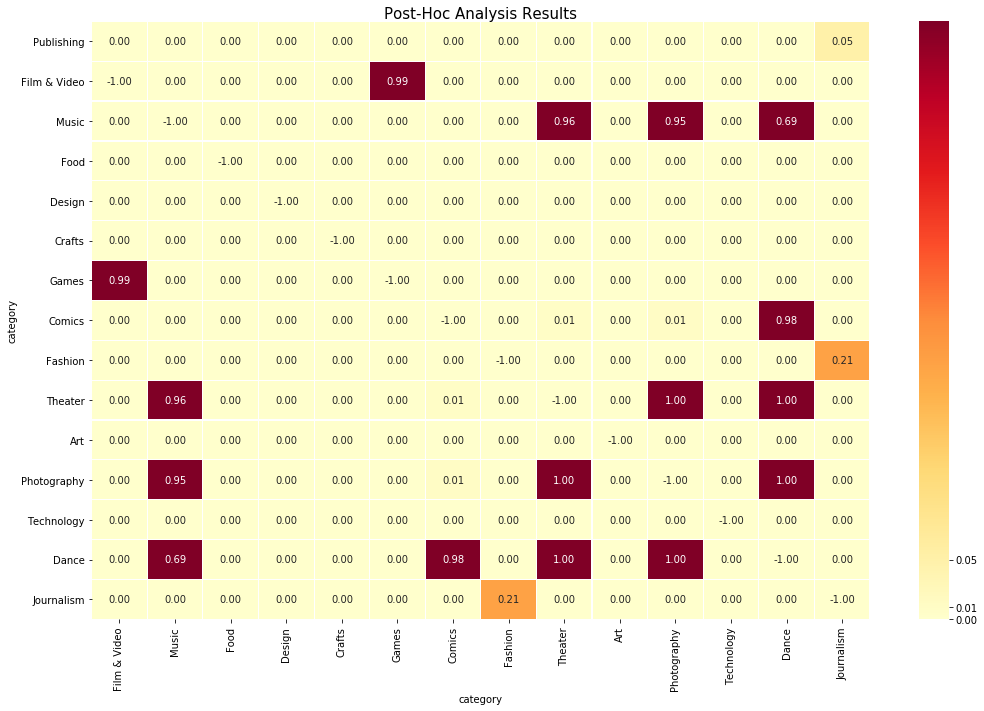

In [248]:
ax = posthoc((15,10),'log_usd_goal_real','main_category',kick_data_cleaned)
ax.set(xlabel = 'category', ylabel = 'category')
plt.show()


__Observations__: This shows that most of the the funding requested for different categories tend to be signficantly different.However, there are some exceptions such as Dance amounts aren't different than Music, Comics, Theatre, or Photography. Also, Film & Video requested amount isn't different than Journalism.

# 4. Bootstrap Confidence Interval

Sadly, the distribution for the pledged dollars (USD_pledged_real) isn't normal. For this reason, I picked a boostrap replicate to calculate the confidence interval for different categories.

In [20]:
def boostrap_percent(data,nrep,q):
    mean = []
    for i in range(nrep):
        sample = np.random.choice(data,size = data.shape[0])
        mean.append(sample.mean())
     #95% confidence level
    percent = np.percentile(mean,q)
    return [percent[0], percent[1],sample.mean()]


In [21]:
boot_pledged = {}

cat = kick_data_cleaned.main_category.unique()

In [22]:
#get boostrap for each category including mean, lower_ci, upper_ci
for p in cat:
    data_p = kick_data_cleaned[kick_data_cleaned.main_category == p]['usd_pledged_real']
    boot_pledged[p] = boostrap_percent(data_p,1000,(2.5, 97.5))

In [23]:
boot_pl = pd.DataFrame.from_dict(boot_pledged,orient = 'index')
boot_pl.rename(columns = {0:'lower_ci', 1: 'upper_ci',2: 'mean', 'index': 'category'},inplace = True)

In [24]:
boot_pl

,lower_ci,upper_ci,mean
Publishing,22132.576269,22612.432692,22525.655515
Film & Video,29250.641360,29682.390535,29359.214532
Music,28814.405079,29263.902105,28941.294580
Food,24542.589556,25233.707660,24754.666165
Design,40758.166763,41480.078862,41399.931327
Crafts,14439.515444,15234.175999,14478.135089
Games,36280.951822,36953.780189,36512.027731
Comics,34027.141231,35006.663241,34650.787041
Fashion,23289.644693,24027.322756,23766.782828
Theater,31561.632241,32449.405436,32261.784477


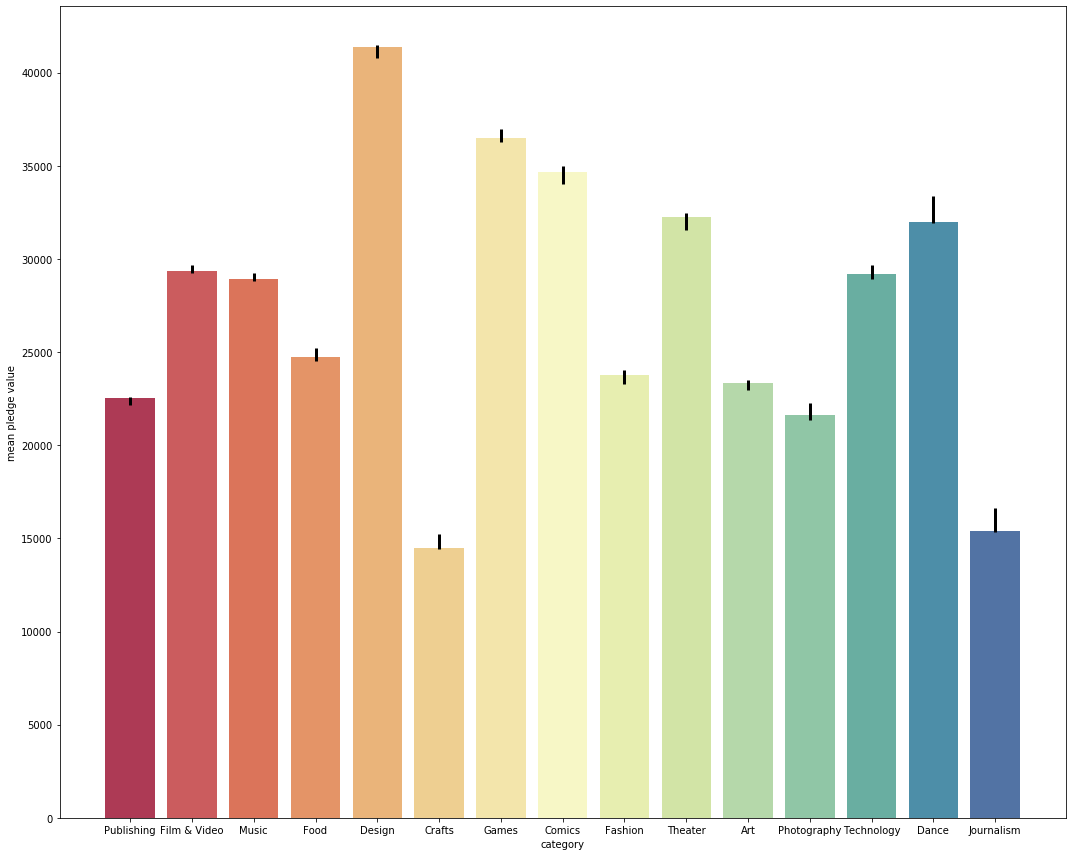

In [28]:
fig = plt.figure(figsize = (15,12))

yerr = [boot_pl['mean']-boot_pl['lower_ci'], boot_pl['upper_ci'] - boot_pl['mean']]

ax = sns.barplot('index','mean',data=boot_pl.reset_index(), ci=None, palette = 'Spectral')
plt.errorbar(x= boot_pl.index,y=boot_pl['mean'],
            yerr=yerr, fmt='none', c= 'k', elinewidth=3, capsize=0)
plt.tight_layout()
plt.xlabel('category')
plt.ylabel('mean pledge value')
plt.show()




__Observation__: The error bars are slightly more disperse for Technology,Dance, and Journalism are wider indicating more uncertainty around confidence intervals. This indicates that there when people request funding for for any of the three, there is wider range of possible values.

## 4. Permutation Tests

 To find out if there is difference between the mean pledge across categories, we must perform permutation test.

$H_{0}$: There is no difference between mean pledged amount between category X and Y. $H_{1}$: There is no difference between the mean pledged amount between category X and Y.

In [30]:
np.random.seed(47)
nreps = 1000


def permutation_reps(data1,data2,size):
    replicates = np.empty(size)
    
    
    for i in range(size):
        #concatenate data
        data = pd.concat([data1,data2])
        perm_data = np.random.permutation(data)
        sample1 = perm_data[:len(data1)]
        sample2 = perm_data[len(data1):]
        
        replicates[i] = abs(np.mean(sample1) - np.mean(sample2))

        
    return replicates

In [31]:
def perm_test_2_groups(data, variable, var1, var2, value, nreps):
    group1 = data[variable == var1][value]
    group2 = data[variable == var2][value]
    
    combined_mean = np.mean(pd.concat([group1,group2]))
    group1_shifted = group1 - np.mean(group1) - combined_mean
    group2_shifted = group2 - np.mean(group2) - combined_mean
    
    p_rep = permutation_reps(group1_shifted,group2_shifted,nreps)
    
    mean_diff = abs(np.mean(group1) - np.mean(group2))
    
    p_val = np.sum(p_rep >= mean_diff)/len(p_rep)
    
    return p_val
    

In [37]:
category = kick_data_cleaned.main_category.unique().tolist()

In [38]:
ls_c = set(combinations(category,2))

In [39]:
df_pval_c = []

df_pval_c = [pd.DataFrame({'group1':l[0], 'group2': l[1],
               'p_val': perm_test_2_groups(kick_data_cleaned,kick_data_cleaned.main_category,
                                           l[0],l[1],'usd_pledged_real',nreps)},index = [0]) for l in ls_c]

In [40]:
df_pval = pd.concat(df_pval_c).reset_index().pivot_table(index = 'group1', columns = 'group2', values = 'p_val')

In [41]:
df_pval

group2,Art,Comics,Crafts,Dance,Design,Fashion,Film & Video,Food,Games,Journalism,Music,Photography,Technology,Theater
group1,,,,,,,,,,,,,,
Art,NaN,NaN,NaN,0.000,NaN,NaN,NaN,NaN,NaN,0.000,NaN,0.000,0.000,NaN
Comics,0.000,NaN,NaN,0.000,NaN,0.0,NaN,NaN,NaN,0.000,NaN,0.000,0.000,0.0
Crafts,0.000,0.0,NaN,0.000,NaN,0.0,NaN,NaN,0.0,0.002,NaN,0.000,0.000,0.0
Dance,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000,NaN,NaN,NaN,NaN
Design,0.000,0.0,0.0,0.000,NaN,0.0,NaN,NaN,0.0,0.000,NaN,0.000,0.000,0.0
Fashion,0.051,NaN,NaN,0.000,NaN,NaN,NaN,NaN,NaN,0.000,NaN,0.000,0.000,0.0
Film & Video,0.000,0.0,0.0,0.000,0.0,0.0,NaN,0.0,0.0,0.000,0.007,0.000,0.492,0.0
Food,0.000,0.0,0.0,0.000,0.0,0.0,NaN,NaN,0.0,0.000,NaN,0.000,0.000,0.0
Games,0.000,0.0,NaN,0.000,NaN,0.0,NaN,NaN,NaN,0.000,NaN,0.000,0.000,0.0


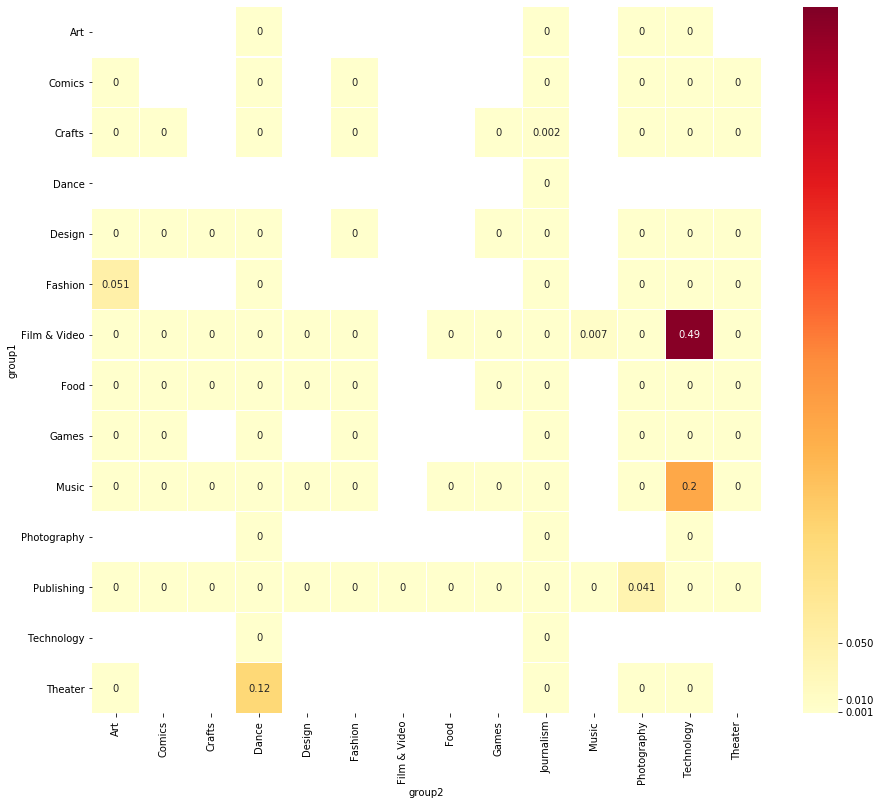

In [42]:
plt.figure(figsize = (15,13))
ax = sns.heatmap(df_pval,cbar_kws={'ticks': [0.001, 0.01,0.05]},
                 vmin=0, vmax=0.5, linewidths=.2,cmap="YlOrRd",annot=True)

__Obsevation__: Based on the resuls, few cateegories aren't statistically different when it comes to average pledged amounts.  Chiefly, Dance & Theater, Technology & Film/Video, Technology & Music 's mean pledged amounts aren't that different.

# 4. Bayensian Stats

In [72]:
LU =  kick_data_cleaned[(kick_data_cleaned.country == 'LU')]
JP =  kick_data_cleaned[(kick_data_cleaned.country == 'JP')]

In [89]:
LU_suc_pl = LU.query("state == 'successful'")['usd_pledged_real']
JP_suc_pl = JP.query("state == 'successful'")['usd_pledged_real']

__Question__: Suppose we want to see if there is any meaningful diference between the mean pledged amount in Japan and the mean pledged amount in LU for successful projects. However, there are very few succcessful projects in both countries! As seen below, there are only 10 in JP and 20 in LU. The sample size is too small for even permutation. Thus, we will use Bayensian statistics to stimule 3000 trials and look at the mean difference. 

$H_{0}$: There is no difference between the mean of pledged amount between JP and LU. $H_{1}$: There is difference between the mean pledged amount between JP and LU.

In [150]:
'Number of successful projects in LU is {} while Number of Successful Projects in JP is {}'.format(len(LU_suc_pl),
                                                                                                          len(JP_suc_pl))

'Number of successful projects in LU is 20 while Number of Successful Projects in JP is 10'

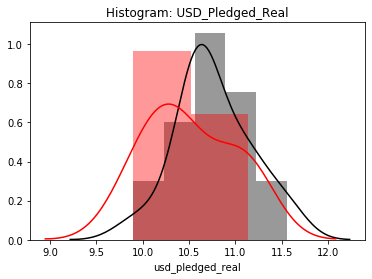

In [151]:

sns.distplot(LU_suc_pl.apply(fkick.log2),color = 'k')
sns.distplot(JP_suc_pl.apply(fkick.log2), color = 'r')
plt.title('Histogram: USD_Pledged_Real')
plt.show()

In [91]:
#get the mean
lu_mean = LU_suc_pl.apply(fkick.log2).mean()
jp_mean = JP_suc_pl.apply(fkick.log2).mean()
lu_std = LU_suc_pl.apply(fkick.log2).std()
jp_std = JP_suc_pl.apply(fkick.log2).std()

In [95]:
import pymc3 as pm
import theano.tensor as T

WARNING (theano.configdefaults): g++ not available, if using conda: `conda install m2w64-toolchain`
C:\Users\daniela.kutleva\AppData\Local\Continuum\anaconda3\lib\site-packages\theano\configdefaults.py:560: UserWarning: DeprecationWarning: there is no c++ compiler.This is deprecated and with Theano 0.11 a c++ compiler will be mandatory
  warnings.warn("DeprecationWarning: there is no c++ compiler."
WARNING (theano.configdefaults): g++ not detected ! Theano will be unable to execute optimized C-implementations (for both CPU and GPU) and will default to Python implementations. Performance will be severely degraded. To remove this warning, set Theano flags cxx to an empty string.
WARNING (theano.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


In [127]:
with pm.Model() as model:
    #mu will be uniform distribution where the min and max come from the data
    mu_lu = pm.Uniform("mu_lu", min(LU_suc_pl.apply(fkick.log2)), max(LU_suc_pl.apply(fkick.log2))) 
    tau_lu = pm.Uniform("tau_lu", 0.001, 1)
    mu_jp = pm.Uniform("mu_jp", min(JP_suc_pl.apply(fkick.log2)), max(JP_suc_pl.apply(fkick.log2)))
    tau_jp = pm.Uniform("tau_jp", 0.001, 1)
    
    #create a normal distribution
    obs_lu = pm.Normal("obs_lu", mu_lu, tau_lu, observed= LU_suc_pl.apply(fkick.log2))
    obs_jp = pm.Normal("obs_jp", mu_jp, tau_jp, observed= JP_suc_pl.apply(fkick.log2))


In [129]:
with model:
    model_lu = pm.Metropolis(vars=[obs_lu, mu_lu, tau_lu])
    
    model_jp = pm.Metropolis(vars=[obs_jp, mu_jp, tau_jp])



In [130]:
with model:
    trace_lu = pm.sample(1500, tune=500,step=model_lu)
    trace_jp = pm.sample(1500, tune=500,step=model_jp)



Multiprocess sampling (2 chains in 2 jobs)
CompoundStep
>CompoundStep
>>Metropolis: [tau_lu]
>>Metropolis: [mu_lu]
>NUTS: [tau_jp, mu_jp]
Sampling 2 chains, 0 divergences: 100%|█████████████████████████████████████████| 4000/4000 [01:01<00:00, 40.81draws/s]
The number of effective samples is smaller than 25% for some parameters.
Multiprocess sampling (2 chains in 2 jobs)
CompoundStep
>CompoundStep
>>Metropolis: [tau_jp]
>>Metropolis: [mu_jp]
>NUTS: [tau_lu, mu_lu]
Sampling 2 chains, 0 divergences: 100%|█████████████████████████████████████████| 4000/4000 [00:52<00:00, 76.00draws/s]
The number of effective samples is smaller than 10% for some parameters.


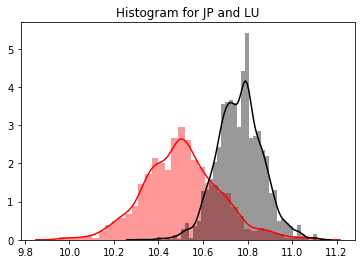

In [152]:
sns.distplot(trace_jp['mu_jp'],color = 'r')
sns.distplot(trace_lu['mu_lu'],color = 'k')
plt.title('Histogram for JP and LU')
plt.show()

In [156]:
mean_obs = lu_mean - jp_mean
mean_bayes =  trace_lu['mu_lu'] - trace_jp['mu_jp']
p_val = np.sum(mean_bayes >= mean_obs)/len(mean_bayes)

print('The p-value is {}:'.format(p_val))

The p-value is 0.5156666666666667:


Thus, there isn't a statistically significant difference between LU and JP. Thus, we fail to reject the null hypothesis.